# Spectrogram?
wav 데이터 해석하는 법

일정 시간동안 wav 데이터 안에 얼마나 다양한 주파수가 포함되었는 가를 보여줌

1차원 waveform 데이터와 달리 2차원 spectrogram 데이터를 입력받아 수행해보기

# 1.  wave data 분석, 처리와 분류

$ mkdir -p ~/aiffel/speech_recognition/data

$ mkdir -p ~/aiffel/speech_recognition/models

$ wget https://aiffelstaticdev.blob.core.windows.net/dataset/speech_wav_8000.npz -P ~/aiffel/speech_recognition/data

In [1]:
import numpy as np
import os

data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

print("✅")

✅


In [2]:
# 데이터셋 살펴보기
print("Wave data shape : ", speech_data["wav_vals"].shape)
print("Label data shape : ", speech_data["label_vals"].shape)
print("✅")

Wave data shape :  (50620, 8000)
Label data shape :  (50620, 1)
✅


# 푸리에 변환

복합파인 음원을 주파수 대역별로 쪼개어 해석하기

# STFT  - short time fourier transform
시간의 길이 쪼개기

시간의 흐름에 따라 신호의 주파수 변했을 때, 어느 시간대에 주파수가 변하는 지 모름.
시간의 길이를 나눠서 푸리에 변환함.

# spectogram


In [3]:
import librosa

def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D
print("✅")

✅


In [4]:
# wave 파일을 for문을 돌려서 spec 함수에 넣어서 변환하기
spec_list = []
for wav in speech_data["wav_vals"]:
    spec_list.append(wav2spec(wav))

spec_list = np.array(spec_list)

In [5]:
print("Spectrogram shape : ",spec_list.shape)

Spectrogram shape :  (50620, 130, 126)


어떻습니까? 1차원의 Waveform 데이터가 2차원의 Spectrogram 데이터로 변환되었습니다.

그렇다면 방금 변환된 Spectrogram을 출력해보겠습니다.

만약에, 우리가 Waveform 데이터 대신 이 Spectrogram 포맷으로 모든 음성 데이터를 변환한 후 음성인식 모델을 학습시킨다면, 과연 Waveform과 비교했을 때 더 나은 성능을 기대할 수 있을까요?

## 1-1. label data 처리

In [6]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

print('Indexed LABEL : ', new_label_value)

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


In [7]:
# Text로 이루어진 라벨 데이터를 학습에 사용하기 위해서 index 형태로 바꿔주는 작업을 하였습니다.
temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])

label_data = np.array(temp)

label_data

array([ 3,  3,  3, ..., 11, 11, 11])

## 1-2 train/test set

## 학습을 위한 데이터 분리

In [8]:
from sklearn.model_selection import train_test_split

# sr = 130*126 #(50620, 130, 126) conv1d
# sr = (130,126) conv2D
train_wav, test_wav, train_label, test_label = train_test_split(spec_list, 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)
print(train_wav)

# train_wav = train_wav.reshape([-1, sr, 1]) # add channel for CNN
train_wav = train_wav.reshape([-1,130,126, 1]) # add channel for CNN 2d

# test_wav = test_wav.reshape([-1, sr, 1])
test_wav = test_wav.reshape([-1, 130,126,1])

print("✅")

[[[2.25948796e-01 2.83187372e-03 4.37496565e-02 ... 1.00246809e-01
   2.20231339e-01 3.90363663e-01]
  [3.15622866e-01 2.60356396e-01 1.99053451e-01 ... 2.86065489e-01
   3.23950380e-01 1.24859184e-01]
  [3.05243045e-01 2.12914392e-01 2.38681182e-01 ... 3.69946599e-01
   2.99007684e-01 1.87774271e-01]
  ...
  [5.52281551e-02 2.58845780e-02 1.75179797e-03 ... 1.44594768e-03
   5.68126095e-03 1.58088580e-02]
  [5.43434210e-02 2.82767359e-02 1.24600192e-03 ... 1.03130566e-04
   5.49111422e-03 9.61262919e-03]
  [5.51733486e-02 2.75525674e-02 7.43534532e-04 ... 3.16205289e-04
   5.24979131e-03 1.02571994e-02]]

 [[9.31036994e-02 5.32200709e-02 7.92028476e-03 ... 2.23458698e-03
   3.43097337e-02 2.95792557e-02]
  [2.13187933e-01 1.34810686e-01 1.41246215e-01 ... 1.35431394e-01
   1.00153044e-01 7.76020139e-02]
  [3.47737372e-01 2.90926576e-01 2.72107333e-01 ... 2.72991687e-01
   2.32971057e-01 8.42936710e-02]
  ...
  [5.46077406e-03 2.74829683e-03 6.47250927e-05 ... 3.14761855e-04
   7.76350

In [9]:
print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test labels : ", test_label.shape)
print("✅")

train data :  (45558, 130, 126, 1)
train labels :  (45558,)
test data :  (5062, 130, 126, 1)
test labels :  (5062,)
✅


# 2. hyper parameters setting

In [10]:
batch_size = 32 # 256 or 512
max_epochs = 5

# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav'

checkpoint_dir

'/home/aiffel/aiffel/speech_recognition/models/wav'

# 3. data setting

* tf.data.Dataset을 이용해서 데이터셋을 구성하겠습니다. 


* tf.data.Dataset.from_tensor_slices 함수에 return 받길 원하는 데이터를 튜플 (data, label) 형태로 넣어서 사용.

* map 함수는 dataset이 데이터를 불러올때마다 동작시킬 데이터 전처리 함수를 매핑해 주는 역할을 합니다. 첫번째 map 함수는 from_tensor_slice 에 입력한 튜플 형태로 데이터를 받으며 return 값으로 어떤 데이터를 반환할지 결정합니다.

In [11]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label
print("✅")

✅


In [12]:
del speech_data
del spec_list

In [13]:
import tensorflow as tf

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)
print("✅")

<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>
✅


# 4. wave spectrogram classification 모델 구현

In [15]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(130,126,1))

x = layers.Conv2D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav = tf.keras.Model(input_tensor, output_tensor)

model_wav.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 130, 126, 1)]     0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 130, 126, 32)      2624      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 130, 126, 32)      82976     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 65, 63, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 65, 63, 64)        165952    
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 65, 63, 64)        331840    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 31, 64)        0   

# 5. Loss & Accuracy graph

## Loss

In [16]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


## training

In [17]:
# callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅


In [18]:
#30분 내외 소요 (메모리 사용량에 주의해 주세요.)
history_wav = model_wav.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

Epoch 1/5
1423/1423 [==============================] - ETA: 0s - loss: 0.6702 - accuracy: 0.7785
Epoch 00001: val_loss improved from inf to 0.30477, saving model to /home/aiffel/aiffel/speech_recognition/models/wav
1423/1423 [==============================] - 201s 141ms/step - loss: 0.6702 - accuracy: 0.7785 - val_loss: 0.3048 - val_accuracy: 0.9031
Epoch 2/5
1423/1423 [==============================] - ETA: 0s - loss: 0.2336 - accuracy: 0.9263
Epoch 00002: val_loss improved from 0.30477 to 0.20588, saving model to /home/aiffel/aiffel/speech_recognition/models/wav
1423/1423 [==============================] - 205s 144ms/step - loss: 0.2336 - accuracy: 0.9263 - val_loss: 0.2059 - val_accuracy: 0.9351
Epoch 3/5
1423/1423 [==============================] - ETA: 0s - loss: 0.1637 - accuracy: 0.9473
Epoch 00003: val_loss improved from 0.20588 to 0.16958, saving model to /home/aiffel/aiffel/speech_recognition/models/wav
1423/1423 [==============================] - 203s 143ms/step - loss: 0.16

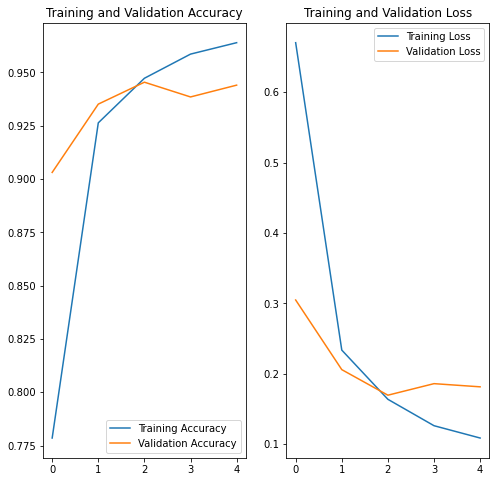

✅


In [19]:
# 학습 결과 Plot
import matplotlib.pyplot as plt

acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']

loss=history_wav.history['loss']
val_loss=history_wav.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

## Evaluation

In [20]:
# Evaluation
model_wav.load_weights(checkpoint_dir)
print("✅")

✅


In [21]:
results = model_wav.evaluate(test_dataset)
print("✅")

159/159 [==============================] - 23s 145ms/step - loss: 0.1695 - accuracy: 0.9455
✅


In [22]:
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))
print("✅")

loss value: 0.169
accuracy value: 94.5476%
✅


# 6. Test dataset을 이용해서 모델의 성능을 평가

## model test

In [23]:
# Test 

inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

# ipd.Audio(batch_xs.reshape(8000,), rate=8000)

label :  left


In [24]:
# 위에서 확인해본 테스트셋의 라벨과 우리 모델의 실제 prediction 결과를 비교해 봅시다.
y_pred_ = model_wav.predict(test_wav)
inv_label_value = {v: k for k, v in label_value.items()}

if np.argmax(y_pred_) == test_label[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')
print("✅")

KeyError: 52059

In [25]:
def spec2wav(wav):
    D = np.abs(librosa.istft(wav))
    return D
data_wav = []
for spec in test_wav:
    wav = spec2wav(spec_list)
    data_wav.append(wav)
data_wav = np.array(data_wav)
data_wav.shape

NameError: name 'spec_list' is not defined

여기선 더이상 어떻게 해야할 지 모르겠다.